# Rapport 
### Introduction 
On va dans le rapport suivant étudier l'efficacité de la stratégie momentum 
pour construire des portefeuilles à partir de 90 paires de cryptomonnaies
Dans un premier temps on va construire ces portefeuilles. On contruira 9 portefeuilles différents comprenenant chacun 10 cryptomonnaies
On va lors de ce rapport utilisé des scripts python ainsi que des graphiques pour illuster nos résultats.


In [5]:
#Import des csv

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import warnings

### On va donc charger toutes les données fournies pour les différents exchanges

In [6]:
warnings.filterwarnings("ignore")

crypto_prices = pd.read_csv("crypto_prices_v2.csv")
# Convert timestamp column to datetime format
crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])

# Set timestamp column as index
crypto_prices.set_index('timestamp', inplace=True)
crypto_prices.head()

,unfi-busd,iota-usd,bhp-usdt,dot-usdt,aave-usdt,nmc-usdt,mx-usdt,dht-usdt,crv-usd,pha-usdt,...,api3-usdt,1inch-usdt,comp-usdt,ersdl-usdt,xor-usdt,ren-usdt,bid-usdt,mkr-usdt,prq-usdt,mta-usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5.562509,0.294552,0.664400,8.798804,87.590000,0.439790,0.1436,0.859310,0.637000,0.118509,...,1.801849,1.167545,144.668659,0.008365,102.525652,0.327979,0.013622,589.914791,0.527962,0.909049
2021-01-02,5.221067,0.286993,0.667342,8.760201,85.937751,0.459137,0.1452,0.992900,0.592534,0.117040,...,1.834821,1.090871,140.000168,0.008287,98.931513,0.312595,0.013083,597.494350,0.460791,1.011624
2021-01-03,6.482086,0.298317,0.667600,9.279673,87.968375,0.507415,0.1388,0.959000,0.621000,0.115557,...,1.889542,1.084320,145.591570,0.009397,101.388139,0.325757,0.014231,672.198175,0.507648,1.160168
2021-01-04,5.851341,0.317800,0.660000,9.465044,102.336182,0.521261,0.1384,1.057248,0.672000,0.114000,...,2.175675,1.076138,145.562839,0.012118,110.576618,0.329471,0.013833,678.422680,0.451232,1.165947
2021-01-05,5.751700,0.354807,0.652600,9.612824,114.077356,0.510710,0.1376,1.171523,0.680000,0.115772,...,2.388763,1.141967,155.225308,0.012469,115.365119,0.335810,0.012865,705.739433,0.608839,1.199186


In [7]:
exchange_info = pd.read_csv("exchange_info_v2.csv")

In [8]:
crix = pd.read_csv("crix.csv", delimiter=";")
crix['date'] = pd.to_datetime(crix['date'])

In [9]:
data_factors = pd.read_csv("data_factors.csv", delimiter=";", header=4)
data_factors = data_factors.rename(columns={data_factors.columns[0]: 'timestamp'})
data_factors = data_factors.iloc[:-1]
# Convert timestamp column to datetime format
data_factors['timestamp'] = pd.to_datetime(data_factors['timestamp'])


In [10]:
momentum_daily = pd.read_csv("momentum_daily.csv", delimiter=";", header=13)
momentum_daily.fillna(0, inplace=True)
momentum_daily = momentum_daily.iloc[:, :-2]

# Convert date column to timestamp format
momentum_daily = momentum_daily.rename(columns={momentum_daily.columns[0]: 'timestamp'})
momentum_daily = momentum_daily.iloc[:-2]
momentum_daily['timestamp'] = pd.to_datetime(momentum_daily['timestamp'])

### Implémentation des différents algorithmes


### I) GetPortfolioCompo


Lors de cette étude nous avons recalculé tous les mois la composition de nos nouveaux portemonnaies
en classant les différentes crypto par leur rentabilité sur les derniers 15 jours.
Le portefeuille 1 est alors celui contenant les cryptos ayant eu la meilleur rentabilité sur sur cette période etr inversement le 9 contient celle ayant le moins performé.
Nos portefeuilles on à l'orifine chacun une valeur de 10000 dollars qui sont equitablementy investit dans les 10 monnaies de chaque portefeuille 
Ainsi on achète 1000 dollars de chacune des cryptos.

In [11]:

rebalancing_dates = pd.date_range(start=crypto_prices.index.min(), end=crypto_prices.index.max(), freq='MS')
rebalancing_dates = rebalancing_dates[1:]
def get_portfolio_compo(df, rebalancing_dates, portfolio_index, horizon):
    portfolio_data = []
    
    for date in rebalancing_dates:
        portfolios = {}
        for i in range(portfolio_index):
            # Sélectionner les données de marché pour la date de rééquilibrage
            market_data = df.loc[date]
            
            # Calculer les rendements sur l'horizon spécifié
            returns = (market_data - df.shift(periods=horizon).loc[date]) / df.shift(periods=horizon).loc[date]
            
            # Classer les cryptomonnaies en fonction des rendements décroissants
            ranked_cryptos = returns.sort_values(ascending=False)
            
            # Extraire les noms des cryptomonnaies pour le portefeuille i+1
            portfolio = ranked_cryptos.iloc[i * 10: (i + 1) * 10]
            
            # Ajouter les noms et les rendements des cryptomonnaies au portefeuille
            portfolio_with_returns = [crypto_name for crypto_name, return_value in portfolio.items()]
            portfolios[f"Portfolio_{i+1}"] = portfolio_with_returns
            
        portfolio_data.append(portfolios)
    
    # Créer un DataFrame à partir des données de portefeuille
    portfolio_df = pd.DataFrame(portfolio_data, index=rebalancing_dates)
    
    return portfolio_df

# Supposons que vous voulez le portefeuille P1 à chaque date de rééquilibrage avec un horizon de 1 jour
portfolios_df = get_portfolio_compo(crypto_prices, rebalancing_dates, portfolio_index=9, horizon=15)


In [142]:
portfolios_df.head()

,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9
2021-02-01,"[fund-usdt, doge-usdt, 1inch-usdt, gala-usdt, ...","[mx-usdt, sand-usdt, crv-usdt, crv-usd, comp-u...","[aave-usdt, sc-usdt, bel-usdt, hnt-usdt, srm-u...","[api3-usdt, hegic-usdt, winx-usdt, xor-usdt, p...","[matic-usdt, bnb-usdc, xem-usdt, eos-usd, eos-...","[weth-usdt, link-usdt, nmc-usdt, storj-usd, xl...","[usdc-usdt, busd-usdt, dai-usdt, steem-usdt, r...","[iota-usd, wxt-usdt, atom-usdt, btc-busd, btc-...","[xmr-usdt, plu-usd, yfi-usdt, bch-usdt, zec-us..."
2021-03-01,"[ersdl-usdt, matic-usdt, senso-usdt, pol-usdt,...","[xem-usdt, xor-usdt, srm-usdt, usdx-usdt, dot-...","[uni-usdt, prq-usdt, tusd-usdc, dai-usdt, busd...","[wbtc-usdt, iota-usd, comp-usdt, sand-usdt, lt...","[sxp-busd, jst-usdt, hnt-usdt, dash-usdt, mkr-...","[trx-usdt, bal-usdt, hex-usdt, doge-usdt, wxt-...","[xlm-usdt, snx-usdt, win-usdt, storj-usd, winx...","[xrp-usdt, zec-usdt, xtz-busd, xtz-usdt, nmc-u...","[etc-usdt, kp3r-usdt, avax-usdt, crv-usd, crv-..."
2021-04-01,"[storj-usd, steem-usdt, winx-usdt, win-usdt, b...","[pol-usdt, sc-usdt, hex-usdt, api3-usdt, sol-u...","[bel-usdt, strong-usdt, bnb-usdt, bnb-usdc, er...","[sxp-busd, etc-usdt, fund-usdt, zec-usdt, sens...","[eth-usdc, xmr-usdt, node-usdt, yfi-usdt, bal-...","[btc-busd, btc-usdc, mana-busd, pha-usdt, aave...","[dash-usdt, kp3r-usdt, link-usdt, snx-usdt, us...","[ren-usdt, cel-usdt, mx-usdt, 1inch-usdt, xem-...","[fti-usdt, unfi-busd, plu-usd, matic-usdt, ava..."
2021-05-01,"[pol-usdt, senso-usdt, ersdl-usdt, matic-usdt,...","[etc-usdt, xmr-usdt, mx-usdt, doge-usdt, bnb-u...","[hnt-usdt, sxp-busd, uni-usdt, bch-usdt, tncc-...","[yfi-usdt, pols-usdt, bhp-usdt, dai-usdt, busd...","[zec-usdt, xrp-usdt, ltc-usdt, avax-usdt, 1inc...","[gala-usdt, cel-usdt, dash-usdt, ltc-usdc, sto...","[bid-usdt, iota-usd, sushi-usd, sushi-usdt, wi...","[snx-usdt, albt-usdt, trx-usdt, nmc-usdt, crv-...","[eos-usdt, eos-usd, xtz-busd, xtz-usdt, api3-u..."
2021-06-01,"[nmc-usdt, hnt-usdt, matic-usdt, hex-usdt, cel...","[albt-usdt, strong-usdt, sand-usdt, btc-busd, ...","[senso-usdt, link-usdt, gala-usdt, uni-usdt, u...","[etc-usdt, api3-usdt, xmr-usdt, hegic-usdt, st...","[yfi-usdt, storj-usd, mx-usdt, snx-usdt, xrp-u...","[xem-usdt, jst-usdt, doge-usdt, xtz-usdt, xtz-...","[ltc-usdt, dht-usdt, bch-usdt, zec-usdt, comp-...","[ersdl-usdt, crv-usdt, iota-usd, winx-usdt, wi...","[bal-usdt, dot-usdt, wxt-usdt, mta-usdt, sxp-b..."


En appellant la fonction get_portfolio_compo on construit on obtient quelles cryptos sont présentes dans chacun des portefeuilles.
En observant leur composition en terme de crypto on remarque que les crypto présentes dans le portefeuille i sont très variable. Dans la majorité des cas
les cryptos présentes dans le portefeuille i sont totalement différentes entre 2 mois qui se suivent. Ainsi une crypto reste rarement à des niveaux de rentabilité similaire par rapport au reste du marché
Celà peut être interprété par la très forte volatilité du marché par des cryptomonnaies, ainsi la rentabilité d'une meme cryptomonnaies varie en général fortement entre 2 mois.


### II) ComputePortfolioValues, UpdateCmpo et UpdateValue


On construit ensuite réellement la composition des différents portefeuilles i en investissant de manière equirépartie tous les mois dans les nouvelles cryptos de ce portefeuille i, et en resctant que ces différents portefeuilles doivent etre autofinancés.

In [12]:
def UpdateValue(date, crypto_prices, portfolio_compo, initial_value):
    if len(portfolio_compo) == 0:
        return initial_value
    portfolio_value = (crypto_prices.loc[date, list(portfolio_compo.keys())] * list(portfolio_compo.values())).sum()
    return portfolio_value


def UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices):
    portfolio_compo.clear()
    portefeuille_actuelle = portfolios_df.loc[date, f"Portfolio_{portfolio_index}"]
    portfolio_compo.update({crypto_name: portfolio_value / (10 * crypto_prices.loc[date, crypto_name]) for crypto_name in portefeuille_actuelle})


def compute_portfolio_values(crypto_prices,portfolios_df, rebalancing_dates, portfolio_index, horizon, initial_value):
    portfolio_compo = {}
    portfolio_values = [initial_value]
    portfolio_value = initial_value

    for date in crypto_prices.index:
        portfolio_value = UpdateValue(date, crypto_prices, portfolio_compo, initial_value)
        if date in rebalancing_dates:
            UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices)
        portfolio_values.append(portfolio_value)

    return portfolio_values





### Etude des portefeuilles 1 à 9:

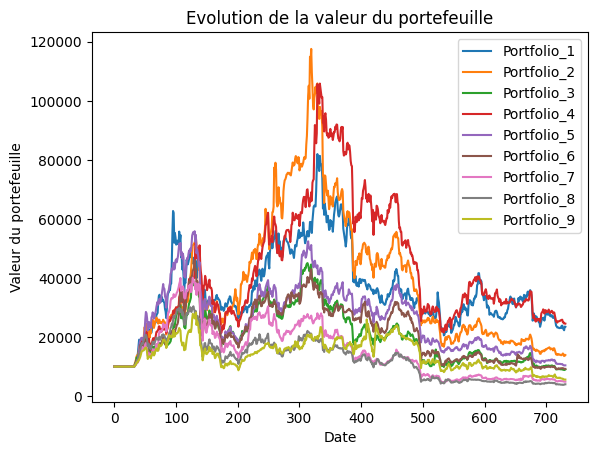

In [118]:


# Initialiser la valeur initiale du portefeuille
initial_portfolio_value = 10000  # Par exemple, 10000 USD

# Indices de portefeuille à considérer
portfolio_indices = range(1, 10)

# Calculer les valeurs des portefeuilles pour les dates de rééquilibrage
portfolio_values_dict = {}


for portfolio_index in portfolio_indices:
    portfolio_values = compute_portfolio_values(crypto_prices,portfolios_df, rebalancing_dates, portfolio_index, horizon=15, initial_value=initial_portfolio_value)
    portfolio_values_dict[f"Portfolio_{portfolio_index}"] = portfolio_values
portfolio_values_df = pd.DataFrame(portfolio_values_dict)

# Afficher les graphiques pour chaque indice de portefeuille
for portfolio_index, portfolio_values in portfolio_values_dict.items():
    plt.plot(portfolio_values, label=portfolio_index)

plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()
plt.show()

On affiche finalement la valeur des portefeuilles de 1 à 9 au cours du temps. On s'attend à ce que les valeurs des portefeuille de faibles indices (1-3) soient en moyenne plus importantes que celles des portfeuilles de grands indices (7-9).

En effet le principe dde la stratégie Momentum s'appuie sur le fait que les actifs les plus performants devraient le rester dans un futur proche.

On ne pense en revanche pas forcément avoir des portefeuilles strictements ordonnées par leurs indices étant donné la forte volatilité des cryptos.

Sur la courbe de l'évolution des valeurs, on remarque dans un premier temps des tendances de marché, lors de la première moitié de la période étudié le marché composé de nos différentes crypto semble etre en tendance hausssière, puis lors de la seconde partie de la période étudiée celle-ci semble passer à la baisse.

Pour ce qui est de l'ordonnancement des valeurs des portefeuilles, on remarque par exemple que le portefeuille 4 qui devrait être etre le quatrième le plus performant si la stratégie du momentum de était parfaite, est enfaite celui qui donne en moyenne la meilleur rentabilité. Il est ensuite suivi par les portefuilles 1 et 2. 

Ces trois portefeuille se détachent des 6 autres portefeuilles en terme de valeur moyenne meme si le portefeuille 2 rejoint les 6 autres à la fin de la période d'étude en terme de valeur. Le portefeuille 9 qui devrait etre le moins performant fini avec une valeur supérieur à celle des portefeuilles 7 et 8 qui ferment la marche des rentabilité sur la période.

### Daily returns

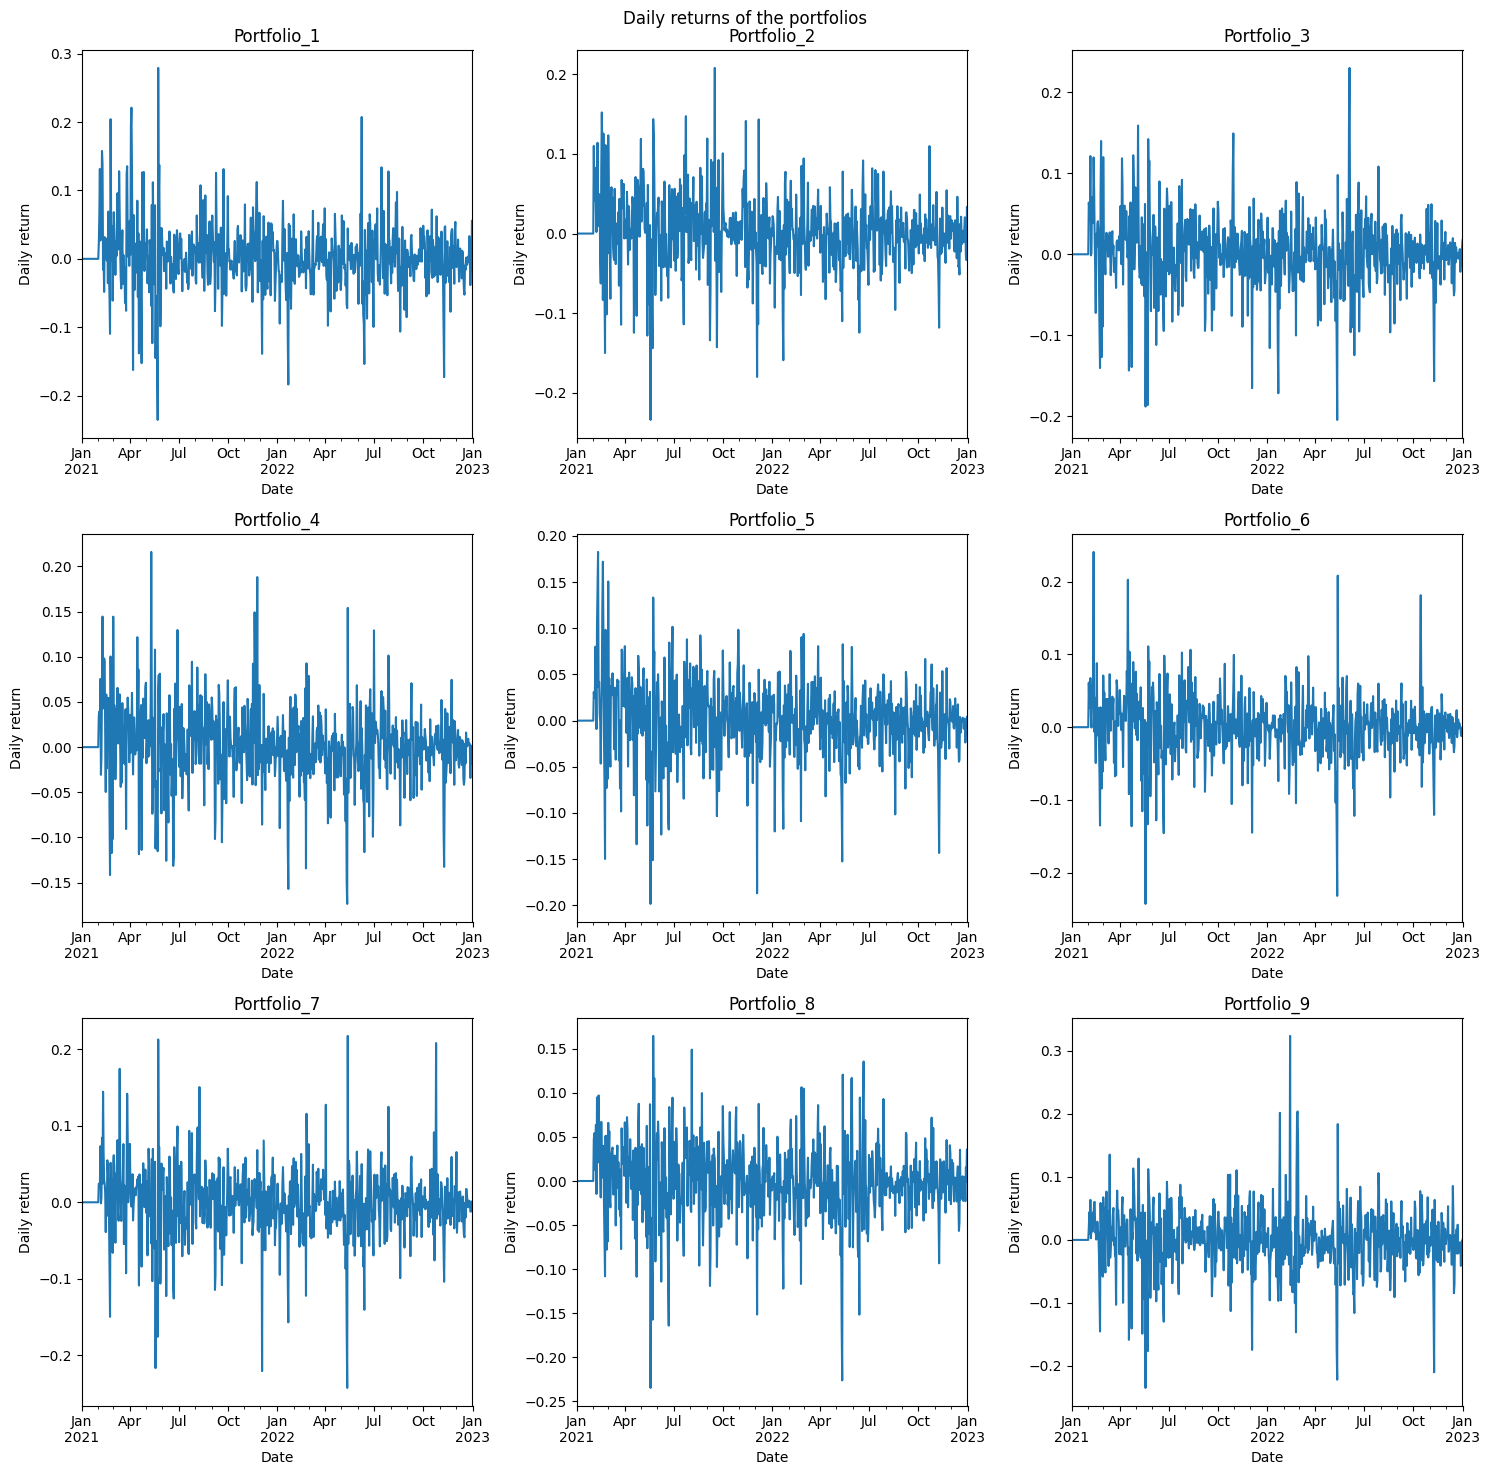

In [120]:

# Supprimer les valeurs NaN
portfolio_values_df = portfolio_values_df.dropna()

# Supprimer la première ligne
portfolio_values_df = portfolio_values_df.iloc[1:]

# Utiliser les timestamp de crypto_prices comme index
portfolio_values_df.index = crypto_prices.index

# Calculer les rendements quotidiens
portfolio_daily_returns = portfolio_values_df.pct_change()

# Diviser le DataFrame en sous-groupes de 3 colonnes
num_subplots = len(portfolio_daily_returns.columns) // 3 + (len(portfolio_daily_returns.columns) % 3 > 0)

fig, axes = plt.subplots(num_subplots, 3, figsize=(15, 5 * num_subplots))
fig.suptitle('Daily returns of the portfolios')

# Afficher les sous-tracés
for i, ax in enumerate(axes.flat):
    if i < len(portfolio_daily_returns.columns):
        col_name = portfolio_daily_returns.columns[i]
        portfolio_daily_returns[col_name].plot(ax=ax, title=col_name, xlabel='Date', ylabel='Daily return')
    else:
        ax.axis('off')  # Masquer les sous-tracés excédentaires s'il y en a

plt.tight_layout()
plt.show()


On va ensuite étudier les rendements journaliers des différents portefeuilles. 

Le graphique qui affiche celle-ci au cours de la période d'étude des portfeuilles ne donne pas d'information claire sur des différences de performance entre les portefeuilles. 

Chacun d'eux connait des piques et des chutes importantes. Pour obtenir d'avantage d'information sur les daily returns on va alors faire une étude statistique de ceux-ci

In [15]:
first_date = data_factors['timestamp'].min()
last_date = crypto_prices.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_df = portfolio_daily_returns.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_df = merged_df.loc[rebalancing_dates[0]:]
merged_df = merged_df.iloc[1:]
variance_merged = merged_df.std()


### Statistiques sur les daily returns


On affiche alors pour les daily returns de chacun des portefeuilles, leur moyenne, leur écart-type leur médianne le max et min ainsi que leur skewness et kurtosis

In [16]:
# Compute the indicators for each returns series
indicators = {}

for column in merged_df.columns:
    returns = merged_df[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }

# Print the indicators for each returns series
for column, values in indicators.items():
    print(f"Indicators for {column}:")
    for indicator, value in values.items():
        print(f"{indicator}: {value}")
    print()

Indicators for Portfolio_1:
Mean: 0.0024189755428441623
Stddev: 0.04909171023676607
Median: 0.00044979488285279423
Min: -0.2354454012165209
Max: 0.27904042829100795
Skewness: 0.35327548213087545
Kurtosis: 4.534457832069984

Indicators for Portfolio_2:
Mean: 0.0015421065537396539
Stddev: 0.04610495381703023
Median: 0.002020784381006502
Min: -0.23399131987880273
Max: 0.2079784041952406
Skewness: -0.16798598793805183
Kurtosis: 2.663403491830193

Indicators for Portfolio_3:
Mean: 0.0008975287440794944
Stddev: 0.04537432510338965
Median: 0.0013356182989860965
Min: -0.20423867559770226
Max: 0.22977989445527802
Skewness: -0.27138779999522405
Kurtosis: 3.439491807244904

Indicators for Portfolio_4:
Mean: 0.0022482924202351863
Stddev: 0.043802916095904185
Median: 0.0027760074353029296
Min: -0.173569784239326
Max: 0.21609208940337776
Skewness: -0.06198672151397107
Kurtosis: 2.7934979474108896

Indicators for Portfolio_5:
Mean: 0.0009571849867231523
Stddev: 0.04212976575367125
Median: 0.002613988

**Expectations**:

On s'attend à obtenir des meilleurs moyennes pour les portefeuilles de faible indices notamment le 1 et le 4 qu'on a identifié comme étant ceux ayant les valeurs les plus élevées au cours de la période d'étude. 

On s'attend également à avoir poour chacun des portfeuille des valeurs d'ecart-type élevées étant données la volatilité du marché des cryptos et donc des max et min éloignés.

**Results**:

On observe bien que les portefeuilles 1 et 4 ont les rendements moyens les plus élevées qui sont tous les 2 supérieurs à 0.22 %.


In [17]:
#on soustrait RF à chaque daily return
merged_df['Portfolio_1'] = merged_df['Portfolio_1'] - merged_df['RF']
merged_df['Portfolio_2'] = merged_df['Portfolio_2'] - merged_df['RF']
merged_df['Portfolio_3'] = merged_df['Portfolio_3'] - merged_df['RF']
merged_df['Portfolio_4'] = merged_df['Portfolio_4'] - merged_df['RF']
merged_df['Portfolio_5'] = merged_df['Portfolio_5'] - merged_df['RF']
merged_df['Portfolio_6'] = merged_df['Portfolio_6'] - merged_df['RF']
merged_df['Portfolio_7'] = merged_df['Portfolio_7'] - merged_df['RF']
merged_df['Portfolio_8'] = merged_df['Portfolio_8'] - merged_df['RF']
merged_df['Portfolio_9'] = merged_df['Portfolio_9'] - merged_df['RF']


### Ratio de Sharpe

In [18]:
#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
sharpe_ratios_portfolios = (merged_df.mean()) / variance_merged
print("Le ratio de sharpe des portefeuilles 1 à 9 :","\n",sharpe_ratios_portfolios[0:9])

Le ratio de sharpe des portefeuilles 1 à 9 : 
 Portfolio_1    0.048674
Portfolio_2    0.032808
Portfolio_3    0.019130
Portfolio_4    0.050654
Portfolio_5    0.022020
Portfolio_6    0.018930
Portfolio_7    0.001003
Portfolio_8   -0.007895
Portfolio_9    0.008511
dtype: float64


### Calcul des ratio des Treynor / alpha de Jensen.

In [109]:

mkt_RF_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df['Mkt-RF'] = mkt_RF_df['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_mkt_RF_df = merged_df.merge(mkt_RF_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df = merged_mkt_RF_df.loc[rebalancing_dates[0]:]
merged_mkt_RF_df = merged_mkt_RF_df.iloc[1:]

merged_mkt_RF_df.head()

,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF
timestamp,,,,,,,,,,,
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015
2021-02-04,0.131356,0.082706,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123
2021-02-05,0.026753,0.080680,0.121114,0.075505,0.080087,0.067547,0.073394,0.036248,0.063519,0.0,0.0058
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058
2021-02-07,0.078834,0.002044,0.001293,-0.009741,-0.009109,-0.000523,0.006110,-0.014703,0.021444,0.0,0.0058


### Regression pour obtenir les betas et alphas de Jensen

In [110]:

# Perform the regression for each portfolio
for portfolio_index in range(1, 10):
    # Select the portfolio values and the Mkt-RF column
    X = merged_mkt_RF_df['Mkt-RF']
    y = merged_mkt_RF_df[f'Portfolio_{portfolio_index}']
    
    # Add a constant term to the independent variable
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Get the intercept (alpha) and slope (beta) coefficients
    alpha = results.params[0]
    beta = results.params[1]
    
    # Calculate the p-value for the alpha coefficient at 10% significance level
    alpha_pvalue = results.pvalues[0]
    

    # Check if the p-value is less than or equal to 0.10
    print(f'Portfolio_{portfolio_index}:')
    print(f'Alpha (Jensen): {alpha}')
    print(f'Alpha p-value: {alpha_pvalue}')
    print(f'Beta (Market): {beta}')
    print()

Portfolio_1:
Alpha (Jensen): 0.002211051965643519
Alpha p-value: 0.21920766897786848
Beta (Market): 0.9668945659725882

Portfolio_2:
Alpha (Jensen): 0.0012218331155011012
Alpha p-value: 0.4692553931948663
Beta (Market): 0.8631491632186671

Portfolio_3:
Alpha (Jensen): 0.0006644494806484474
Alpha p-value: 0.6925391675828703
Beta (Market): 0.7247641113387633

Portfolio_4:
Alpha (Jensen): 0.002057938243443774
Alpha p-value: 0.20441593434497773
Beta (Market): 0.72863776374779

Portfolio_5:
Alpha (Jensen): 0.0007752319798164464
Alpha p-value: 0.6190540364700128
Beta (Market): 0.6985207364816501

Portfolio_6:
Alpha (Jensen): 0.0006241096234047731
Alpha p-value: 0.6998948827264182
Beta (Market): 0.7716782988465907

Portfolio_7:
Alpha (Jensen): -0.00013394788592596563
Alpha p-value: 0.9373083977070089
Beta (Market): 0.9298103120554839

Portfolio_8:
Alpha (Jensen): -0.0005540491522037425
Alpha p-value: 0.7301528568436357
Beta (Market): 0.8879396501442148

Portfolio_9:
Alpha (Jensen): 0.00024568

### Ratio de Treynor

In [21]:

#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
treynor_ratios_portfolios = (merged_df.mean()) / beta
print("Le ratio de treynor des portefeuilles 1 à 9 sont :","\n",treynor_ratios_portfolios[0:9])

Le ratio de treynor des portefeuilles 1 à 9 sont : 
 Portfolio_1    0.002354
Portfolio_2    0.001490
Portfolio_3    0.000855
Portfolio_4    0.002186
Portfolio_5    0.000914
Portfolio_6    0.000819
Portfolio_7    0.000046
Portfolio_8   -0.000342
Portfolio_9    0.000424
dtype: float64


### Simulation de FAMA & FRENCH

In [22]:
fm_portfolios = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_portfolios['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_portfolios['Mkt-RF'] = fm_portfolios['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_portfolios['HML'].fillna(method='ffill', inplace=True)
fm_portfolios['HML'] = fm_portfolios['HML'].str.replace(',', '.').astype(float)/100
fm_portfolios['SMB'].fillna(method='ffill', inplace=True)
fm_portfolios['SMB'] = fm_portfolios['SMB'].str.replace(',', '.').astype(float)/100

fm_portfolios = merged_df.merge(fm_portfolios, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_portfolios = fm_portfolios.loc[rebalancing_dates[0]:]
fm_portfolios.head()


,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF,HML,SMB
timestamp,,,,,,,,,,,,,
2021-02-02,0.021151,0.110044,0.063678,0.034783,0.030922,0.061237,0.024386,0.047010,0.018269,0.0,0.0148,-0.0108,-0.0085
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015,0.0070,0.0043
2021-02-04,0.131356,0.082706,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123,0.0037,0.0038
2021-02-05,0.026753,0.080680,0.121114,0.075505,0.080087,0.067547,0.073394,0.036248,0.063519,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058,-0.0047,0.0107


In [98]:

# Select the independent variables (Mkt-RF, SMB, HML)
X = fm_portfolios[['Mkt-RF', 'SMB', 'HML']]

# Select the dependent variables (portfolio returns)
y = fm_portfolios[['Portfolio_1', 'Portfolio_2', 'Portfolio_3', 'Portfolio_4', 'Portfolio_5', 'Portfolio_6', 'Portfolio_7', 'Portfolio_8', 'Portfolio_9']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}
alpha_pvalues = {}

for portfolio in y.columns:
    # Select the current portfolio as the dependent variable
    current_y = y[portfolio]

    # Perform OLS regression
    model = sm.OLS(current_y, X)
    results = model.fit()

    # Get the coefficients
    Bmarket = results.params['Mkt-RF']
    Bsmb = results.params['SMB']
    Bhml = results.params['HML']

    # Get the alpha (intercept)
    alpha = results.params['const']
    #get the p-value for the alpha coefficient
    alpha_pvalue = results.pvalues[0]

    # Store coefficients and alpha in dictionaries
    coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
    alphas[portfolio] = alpha
    alpha_pvalues[portfolio] = alpha_pvalue


# Print the coefficients and alphas for each portfolio
print("Coefficients:")
for portfolio, coeffs in coefficients.items():
    print(f"{portfolio}: Bmarket={coeffs['Bmarket']}, Bsmb={coeffs['Bsmb']}, Bhml={coeffs['Bhml']}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: Alpha={alpha} p-value={alpha_pvalues[portfolio]}")


Coefficients:
Portfolio_1: Bmarket=0.961501598136943, Bsmb=0.3386565420854252, Bhml=0.1523865755762788
Portfolio_2: Bmarket=0.8988204026970165, Bsmb=-0.003076044116250784, Bhml=0.06741455974486985
Portfolio_3: Bmarket=0.7401957600397763, Bsmb=0.00881385068594252, Bhml=0.030466685721396217
Portfolio_4: Bmarket=0.7762491242776941, Bsmb=-0.12414204804965315, Bhml=0.06725971211621647
Portfolio_5: Bmarket=0.6892136830344119, Bsmb=0.1484986630421088, Bhml=0.0405720089702994
Portfolio_6: Bmarket=0.7970888501534195, Bsmb=-0.15314776212462597, Bhml=-0.02078956105174091
Portfolio_7: Bmarket=0.9427518630452788, Bsmb=-0.0814378599373918, Bhml=-0.0072823761154558134
Portfolio_8: Bmarket=0.9407711446358734, Bsmb=-0.24642929482987236, Bhml=0.016681216833179163
Portfolio_9: Bmarket=1.0720521800696237, Bsmb=-0.04226341823265052, Bhml=0.14171557836175208

Alphas:
Portfolio_1: Alpha=0.00212010236296028 p-value=0.24134551227129192
Portfolio_2: Alpha=0.0012739655921453897 p-value=0.4550906704716836
Portfol

In [124]:

# Création d'un DataFrame vide pour les cryptomonnaies centralisées
centralized_df = pd.DataFrame()

# Liste des noms de cryptomonnaies centralisées
centralized_crypto_names = exchange_info[exchange_info['CeX'] == True]['Unnamed: 0'].values

# Parcourir les colonnes du DataFrame crypto_prices
for crypto in crypto_prices.columns:
    # Vérifier si la cryptomonnaie est centralisée
    if crypto in centralized_crypto_names:
        # Ajouter la cryptomonnaie au DataFrame centralized_df
        centralized_df[crypto] = crypto_prices[crypto]

# on fait pareil pour les cryptomonnaies décentralisées
decentralized_df = pd.DataFrame()
decentralized_crypto_names = exchange_info[exchange_info['DeX'] == True]['Unnamed: 0'].values
for crypto in crypto_prices.columns:
    if crypto in decentralized_crypto_names:
        decentralized_df[crypto] = crypto_prices[crypto]
centralized_df.head()
    

,unfi-busd,iota-usd,bhp-usdt,dot-usdt,aave-usdt,nmc-usdt,mx-usdt,dht-usdt,crv-usd,pha-usdt,...,gala-usdt,api3-usdt,1inch-usdt,comp-usdt,ersdl-usdt,xor-usdt,ren-usdt,mkr-usdt,prq-usdt,mta-usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5.562509,0.294552,0.664400,8.798804,87.590000,0.439790,0.1436,0.859310,0.637000,0.118509,...,0.001185,1.801849,1.167545,144.668659,0.008365,102.525652,0.327979,589.914791,0.527962,0.909049
2021-01-02,5.221067,0.286993,0.667342,8.760201,85.937751,0.459137,0.1452,0.992900,0.592534,0.117040,...,0.001151,1.834821,1.090871,140.000168,0.008287,98.931513,0.312595,597.494350,0.460791,1.011624
2021-01-03,6.482086,0.298317,0.667600,9.279673,87.968375,0.507415,0.1388,0.959000,0.621000,0.115557,...,0.001182,1.889542,1.084320,145.591570,0.009397,101.388139,0.325757,672.198175,0.507648,1.160168
2021-01-04,5.851341,0.317800,0.660000,9.465044,102.336182,0.521261,0.1384,1.057248,0.672000,0.114000,...,0.001310,2.175675,1.076138,145.562839,0.012118,110.576618,0.329471,678.422680,0.451232,1.165947
2021-01-05,5.751700,0.354807,0.652600,9.612824,114.077356,0.510710,0.1376,1.171523,0.680000,0.115772,...,0.001525,2.388763,1.141967,155.225308,0.012469,115.365119,0.335810,705.739433,0.608839,1.199186


### Etude du portefeuille long sur 1 et short sur 9

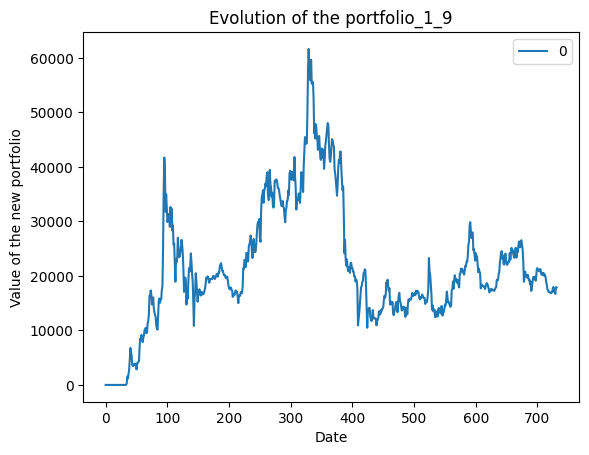

In [25]:
# Get the values of Portfolio 1 and the last portfolio
portfolio_1_values = portfolio_values_dict["Portfolio_1"]
last_portfolio_values = portfolio_values_dict[f"Portfolio_{len(portfolio_values_dict)}"]

# Create a new portfolio that buys Portfolio 1 and sells the last portfolio
portfolio_1_9 = pd.Series(portfolio_1_values) - pd.Series(last_portfolio_values)
#on convertit portfolio_1_9 en dataframe
portfolio_1_9 = pd.DataFrame(portfolio_1_9)
# Plot the values of all portfolios
portfolio_values_df = pd.DataFrame(portfolio_values_dict)
# Plot the new portfolio values P1_9
portfolio_1_9.plot(title='Evolution of the portfolio_1_9', xlabel='Date', ylabel='Value of the new portfolio')
plt.show()


### Daily returns

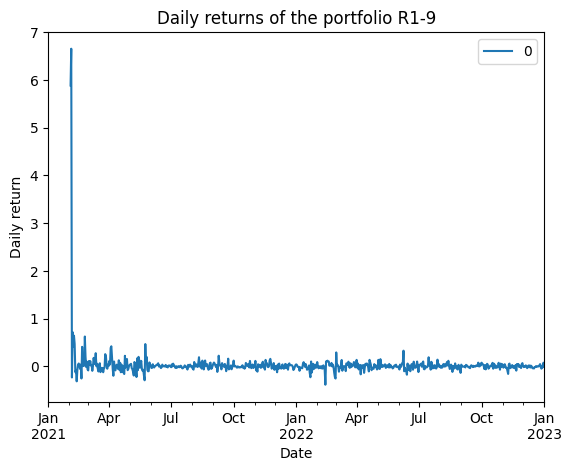

In [26]:
portfolio_1_9 = portfolio_1_9.iloc[1:]
portfolio_1_9.index = crypto_prices.index
portfolio_1_9_daily_returns = portfolio_1_9.pct_change()
portfolio_1_9_daily_returns.plot(title='Daily returns of the portfolio R1-9', xlabel='Date', ylabel='Daily return')
plt.show()

On fait R-Rf pour faciliter les calculs suivants

In [27]:
rf_df_1_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df_1_9['RF'].fillna(method='ffill', inplace=True)
rf_df_1_9['RF'] = rf_df_1_9['RF'].str.replace(',', '.').astype(float)/100

merged_df_1_9 = portfolio_1_9_daily_returns.merge(rf_df_1_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_df_1_9 = merged_df_1_9.loc[rebalancing_dates[0]:]
merged_df_1_9 = merged_df_1_9.iloc[2:]
variance_merged_1_9 = merged_df_1_9.std()
merged_df_1_9[0] = merged_df_1_9[0] - merged_df_1_9['RF']
merged_df_1_9.head()

,0,RF
timestamp,,
2021-02-03,5.880045,0.0
2021-02-04,6.650282,0.0
2021-02-05,-0.233401,0.0
2021-02-06,0.716195,0.0
2021-02-07,0.407996,0.0


### Simulation de FAMA & FRENCH

### Ratio de sharpe Portefeuille P1-9

In [28]:
sharpe_ratio_p1_9 = merged_df_1_9.mean() / variance_merged_1_9
print("Le ratio de sharpe du portefeuille P1-9 est :", sharpe_ratio_p1_9[0])

Le ratio de sharpe du portefeuille P1-9 est : 0.0727745536022349


In [29]:
mkt_RF_df_1_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df_1_9['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df_1_9['Mkt-RF'] = mkt_RF_df_1_9['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_mkt_RF_df_1_9 = portfolio_1_9_daily_returns.merge(mkt_RF_df_1_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df_1_9 = merged_mkt_RF_df_1_9.loc[rebalancing_dates[0]:]
merged_mkt_RF_df_1_9 = merged_mkt_RF_df_1_9.iloc[2:]

### Simulation Alpha de Jensen

In [99]:
# Select the portfolio values and the Mkt-RF column
X = merged_mkt_RF_df_1_9['Mkt-RF']
y = merged_mkt_RF_df_1_9[0]

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Get the intercept (alpha) and slope (beta) coefficients
alpha_1_9 = results.params[0]
beta_1_9 = results.params[1]
alpha_pvalue_1_9 = results.pvalues[0]

# Print the alpha and beta coefficients
print(f'Portfolio_1_9:')
print(f'Alpha (Jensen): {alpha_1_9} p-value: {alpha_pvalue_1_9}')
print(f'Beta (Market): {beta_1_9}')
print()

Portfolio_1_9:
Alpha (Jensen): 0.02506597073992868 p-value: 0.05691916758241068
Beta (Market): 1.698598754495311



### Ratio de Treynor

In [31]:
#on calcul le ration de sharpe pour le portefeuille P1-9
treynor_ratios_1_9_portfolio = (merged_mkt_RF_df_1_9.mean() ) / beta_1_9
print("Le ratio de treynor des portefeuilles 1 à 9 sont :","\n",treynor_ratios_1_9_portfolio[0])

Le ratio de treynor des portefeuilles 1 à 9 sont : 
 0.014913585708305185


### Simulation FAMA FRENCH

In [101]:
fm_portfolio_1_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_portfolio_1_9['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_portfolio_1_9['Mkt-RF'] = fm_portfolio_1_9['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_portfolio_1_9['HML'].fillna(method='ffill', inplace=True)
fm_portfolio_1_9['HML'] = fm_portfolio_1_9['HML'].str.replace(',', '.').astype(float)/100
fm_portfolio_1_9['SMB'].fillna(method='ffill', inplace=True)
fm_portfolio_1_9['SMB'] = fm_portfolio_1_9['SMB'].str.replace(',', '.').astype(float)/100

fm_portfolio_1_9 = merged_df_1_9.merge(fm_portfolio_1_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_portfolio_1_9 = fm_portfolio_1_9.loc[rebalancing_dates[0]:]
X = fm_portfolio_1_9[['Mkt-RF', 'SMB', 'HML']]

fm_portfolio_1_9.head()


,0,RF,Mkt-RF,HML,SMB
timestamp,,,,,
2021-02-03,5.880045,0.0,0.0015,0.0070,0.0043
2021-02-04,6.650282,0.0,0.0123,0.0037,0.0038
2021-02-05,-0.233401,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.716195,0.0,0.0058,-0.0047,0.0107
2021-02-07,0.407996,0.0,0.0058,-0.0047,0.0107


In [102]:

# Select the independent variables (Mkt-RF, SMB, HML)

# Select the dependent variables (portfolio returns)
y = fm_portfolio_1_9[0]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}
alpha_pvalues = {}


# Select the current portfolio as the dependent variable
current_y = y

# Perform OLS regression
model = sm.OLS(current_y, X)
results = model.fit()

# Get the coefficients
Bmarket = results.params['Mkt-RF']
Bsmb = results.params['SMB']
Bhml = results.params['HML']

# Get the alpha (intercept)
alpha = results.params['const']
#get the p-value for the alpha coefficient
alpha_pvalue = results.pvalues[0]

# Store coefficients and alpha in dictionaries
coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
alphas[portfolio] = alpha
alpha_pvalues[portfolio] = alpha_pvalue

# Print the coefficients and alphas for each portfolio
print("Coefficients:")
for portfolio, coeffs in coefficients.items():
    print(f"{portfolio}: Bmarket={coeffs['Bmarket']}, Bsmb={coeffs['Bsmb']}, Bhml={coeffs['Bhml']}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: Alpha={alpha} p-value={alpha_pvalues[portfolio]}")


Coefficients:
Portfolio_9: Bmarket=1.7561116947888051, Bsmb=2.9302226234403106, Bhml=1.6474177539153108

Alphas:
Portfolio_9: Alpha=0.023730286665481073 p-value=0.07319651452770373


# Etude de R1 - R9

### Daily returns

<AxesSubplot:title={'center':'Daily returns of the portfolio R1-R9'}, xlabel='Date', ylabel='Daily return'>

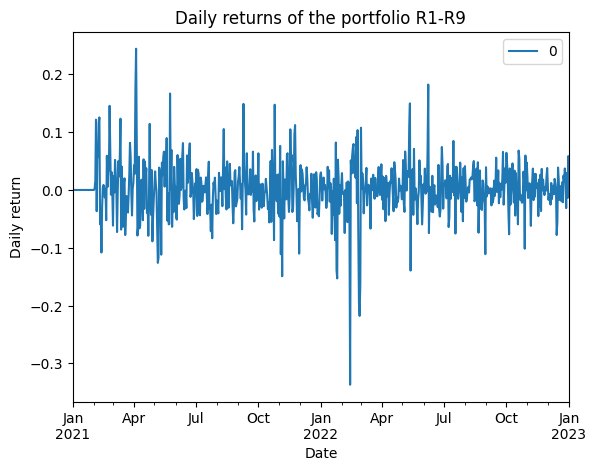

In [34]:
#on calcul et on affiche la difference de rentabilite entre le portefeuille 1 et le 9
portfolio_1_minus_9 = portfolio_daily_returns["Portfolio_1"] - portfolio_daily_returns["Portfolio_9"]
portfolio_1_minus_9 = pd.DataFrame(portfolio_1_minus_9)

portfolio_1_minus_9.index = crypto_prices.index
portfolio_1_minus_9.plot(title='Daily returns of the portfolio R1-R9', xlabel='Date', ylabel='Daily return')


In [103]:
first_date = data_factors['timestamp'].min()
last_date = crypto_prices.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_1_minus_9_df = portfolio_1_minus_9.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_1_minus_9_df = merged_1_minus_9_df.loc[rebalancing_dates[0]:]
merged_1_minus_9_df = merged_1_minus_9_df.iloc[1:]
#on rename la colonne
merged_1_minus_9_df = merged_1_minus_9_df.rename(columns={merged_1_minus_9_df.columns[0]: 'R1-R9'})
merged_1_minus_9_df.head()

,R1-R9,RF
timestamp,,
2021-02-02,0.002883,0.0
2021-02-03,0.016474,0.0
2021-02-04,0.121600,0.0
2021-02-05,-0.036766,0.0
2021-02-06,0.065962,0.0


### Statistiques sur les daily returns

In [104]:
# Compute the indicators for each returns series
indicators = {}

for column in merged_1_minus_9_df:
    returns = merged_1_minus_9_df[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }

# Indicator for R1-R9
print("Indicators for R1-R9:")
for indicator, value in indicators['R1-R9'].items():
    print(f"{indicator}: {value}")
print()

Indicators for R1-R9:
Mean: 0.001959130224164338
Stddev: 0.047500854595714334
Median: 0.0020024965959515306
Min: -0.3367621098981606
Max: 0.244234996443078
Skewness: -0.4120878382974035
Kurtosis: 6.388701648656294



### Ratio de Sharpe

In [37]:
ratio_sharpe_portfolio_1_minus_9 = portfolio_1_minus_9.mean() / portfolio_1_minus_9.std()
print("Le ratio de Sharpe de portfolio_1_minus_9 est :", ratio_sharpe_portfolio_1_minus_9[0])


Le ratio de Sharpe de portfolio_1_minus_9 est : 0.04035864175686419


### Simulation Alpha de Jensen

In [105]:

mkt_RF_df_1_minus_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df_1_minus_9['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df_1_minus_9['Mkt-RF'] = mkt_RF_df_1_minus_9['Mkt-RF'].str.replace(',', '.').astype(float)

merged_mkt_RF_df_1_minus_9 = portfolio_1_minus_9.merge(mkt_RF_df_1_minus_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df_1_minus_9 = merged_mkt_RF_df_1_minus_9.loc[rebalancing_dates[0]:]
merged_mkt_RF_df_1_minus_9 = merged_mkt_RF_df_1_minus_9.iloc[2:]

In [106]:
# Select the portfolio values and the Mkt-RF column
X = merged_mkt_RF_df_1_minus_9['Mkt-RF']
y = merged_mkt_RF_df_1_minus_9[0]

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Get the intercept (alpha) and slope (beta) coefficients
alpha_1_minus_9 = results.params[0]
alpha_pvalue_1_minus_9 = results.pvalues[0]
beta_1_minus_9 = results.params[1]

# Print the alpha and beta coefficients
print(f'Portfolio_1_minus_9:')
print(f'Alpha (Jensen): {alpha_1_minus_9} p-value: {alpha_pvalue_1_minus_9}')
print(f'Beta (Market): {beta_1_minus_9}')
print()


Portfolio_1_minus_9:
Alpha (Jensen): 0.001965368222534794 p-value: 0.2753967148932481
Beta (Market): -0.00048240991735705116



### Ratio de Treynor

In [40]:
#on calcul le ration de sharpe pour le portefeuille R1-R9
treynor_ratios_1_minus_9_portfolio = (merged_mkt_RF_df_1_minus_9.mean() ) / beta_1_minus_9
print("Le ratio de treynor du portefeuille 1 moins le portefeuile 9 :","\n",treynor_ratios_1_minus_9_portfolio[0])

Le ratio de treynor du portefeuille 1 moins le portefeuile 9 : 
 -4.058389289772023


### Simulation de Fama FRENCH

In [112]:
fm_portfolio_1_minus_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_portfolio_1_minus_9['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_portfolio_1_minus_9['Mkt-RF'] = fm_portfolio_1_minus_9['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_portfolio_1_minus_9['HML'].fillna(method='ffill', inplace=True)
fm_portfolio_1_minus_9['HML'] = fm_portfolio_1_minus_9['HML'].str.replace(',', '.').astype(float)/100
fm_portfolio_1_minus_9['SMB'].fillna(method='ffill', inplace=True)
fm_portfolio_1_minus_9['SMB'] = fm_portfolio_1_minus_9['SMB'].str.replace(',', '.').astype(float)/100

fm_portfolio_1_minus_9 = merged_1_minus_9_df.merge(fm_portfolio_1_minus_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_portfolio_1_minus_9 = fm_portfolio_1_minus_9.loc[rebalancing_dates[0]:]
X = fm_portfolio_1_minus_9[['Mkt-RF', 'SMB', 'HML']]

fm_portfolio_1_minus_9.head()


,R1-R9,RF,Mkt-RF,HML,SMB
timestamp,,,,,
2021-02-02,0.002883,0.0,0.0148,-0.0108,-0.0085
2021-02-03,0.016474,0.0,0.0015,0.0070,0.0043
2021-02-04,0.121600,0.0,0.0123,0.0037,0.0038
2021-02-05,-0.036766,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.065962,0.0,0.0058,-0.0047,0.0107


In [113]:

# Select the independent variables (Mkt-RF, SMB, HML)

# Select the dependent variables (portfolio returns)
y = fm_portfolio_1_minus_9['R1-R9']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}
alpha_pvalues = {}

# Select the current portfolio as the dependent variable
current_y = y

# Perform OLS regression
model = sm.OLS(current_y, X)
results = model.fit()

# Get the coefficients
Bmarket = results.params['Mkt-RF']
Bsmb = results.params['SMB']
Bhml = results.params['HML']

# Get the alpha (intercept)
alpha = results.params['const']
#get the p-value for the alpha coefficient
alpha_pvalue = results.pvalues[0]

# Store coefficients and alpha in dictionaries
coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
alphas[portfolio] = alpha
alpha_pvalues[portfolio] = alpha_pvalue

# Print the coefficients and alphas for each portfolio
print("Coefficients:")
for portfolio, coeffs in coefficients.items():
    print(f"{portfolio}: Bmarket={coeffs['Bmarket']}, Bsmb={coeffs['Bsmb']}, Bhml={coeffs['Bhml']}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: Alpha={alpha} p-value={alpha_pvalues[portfolio]}")


Coefficients:
Portfolio_9: Bmarket=-0.11055058193268041, Bsmb=0.3809199603180756, Bhml=0.010670997214526924

Alphas:
Portfolio_9: Alpha=0.002054454690577423 p-value=0.2568144775972342


# Etude des crypto centralisées

In [43]:
portfolio_1_8_centralized = get_portfolio_compo(centralized_df, rebalancing_dates, portfolio_index=8, horizon=15)
premier_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=1, horizon=15, initial_value=initial_portfolio_value)
deuxieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=2, horizon=15, initial_value=initial_portfolio_value)
troisieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=3, horizon=15, initial_value=initial_portfolio_value)
quatrieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=4, horizon=15, initial_value=initial_portfolio_value)
cinquieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=5, horizon=15, initial_value=initial_portfolio_value)
sixieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=6, horizon=15, initial_value=initial_portfolio_value)
septieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=7, horizon=15, initial_value=initial_portfolio_value)
huitieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=8, horizon=15, initial_value=initial_portfolio_value)


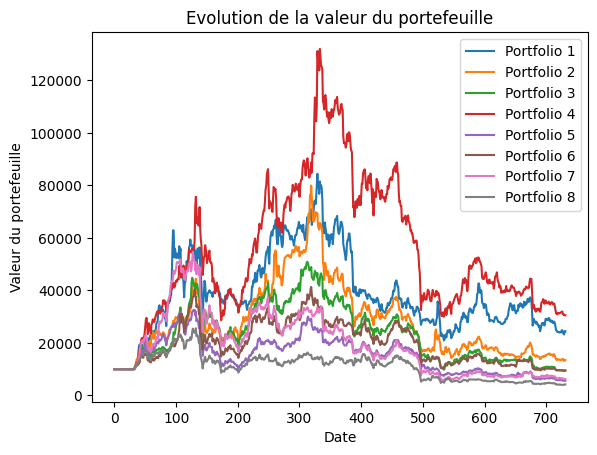

In [44]:
plt.plot(premier_portefeuille_centralise, label="Portfolio 1")
plt.plot(deuxieme_portefeuille_centralise, label="Portfolio 2")
plt.plot(troisieme_portefeuille_centralise, label="Portfolio 3")
plt.plot(quatrieme_portefeuille_centralise, label="Portfolio 4")
plt.plot(cinquieme_portefeuille_centralise, label="Portfolio 5")
plt.plot(sixieme_portefeuille_centralise, label="Portfolio 6")
plt.plot(septieme_portefeuille_centralise, label="Portfolio 7")
plt.plot(huitieme_portefeuille_centralise, label="Portfolio 8")
plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()    
plt.show()

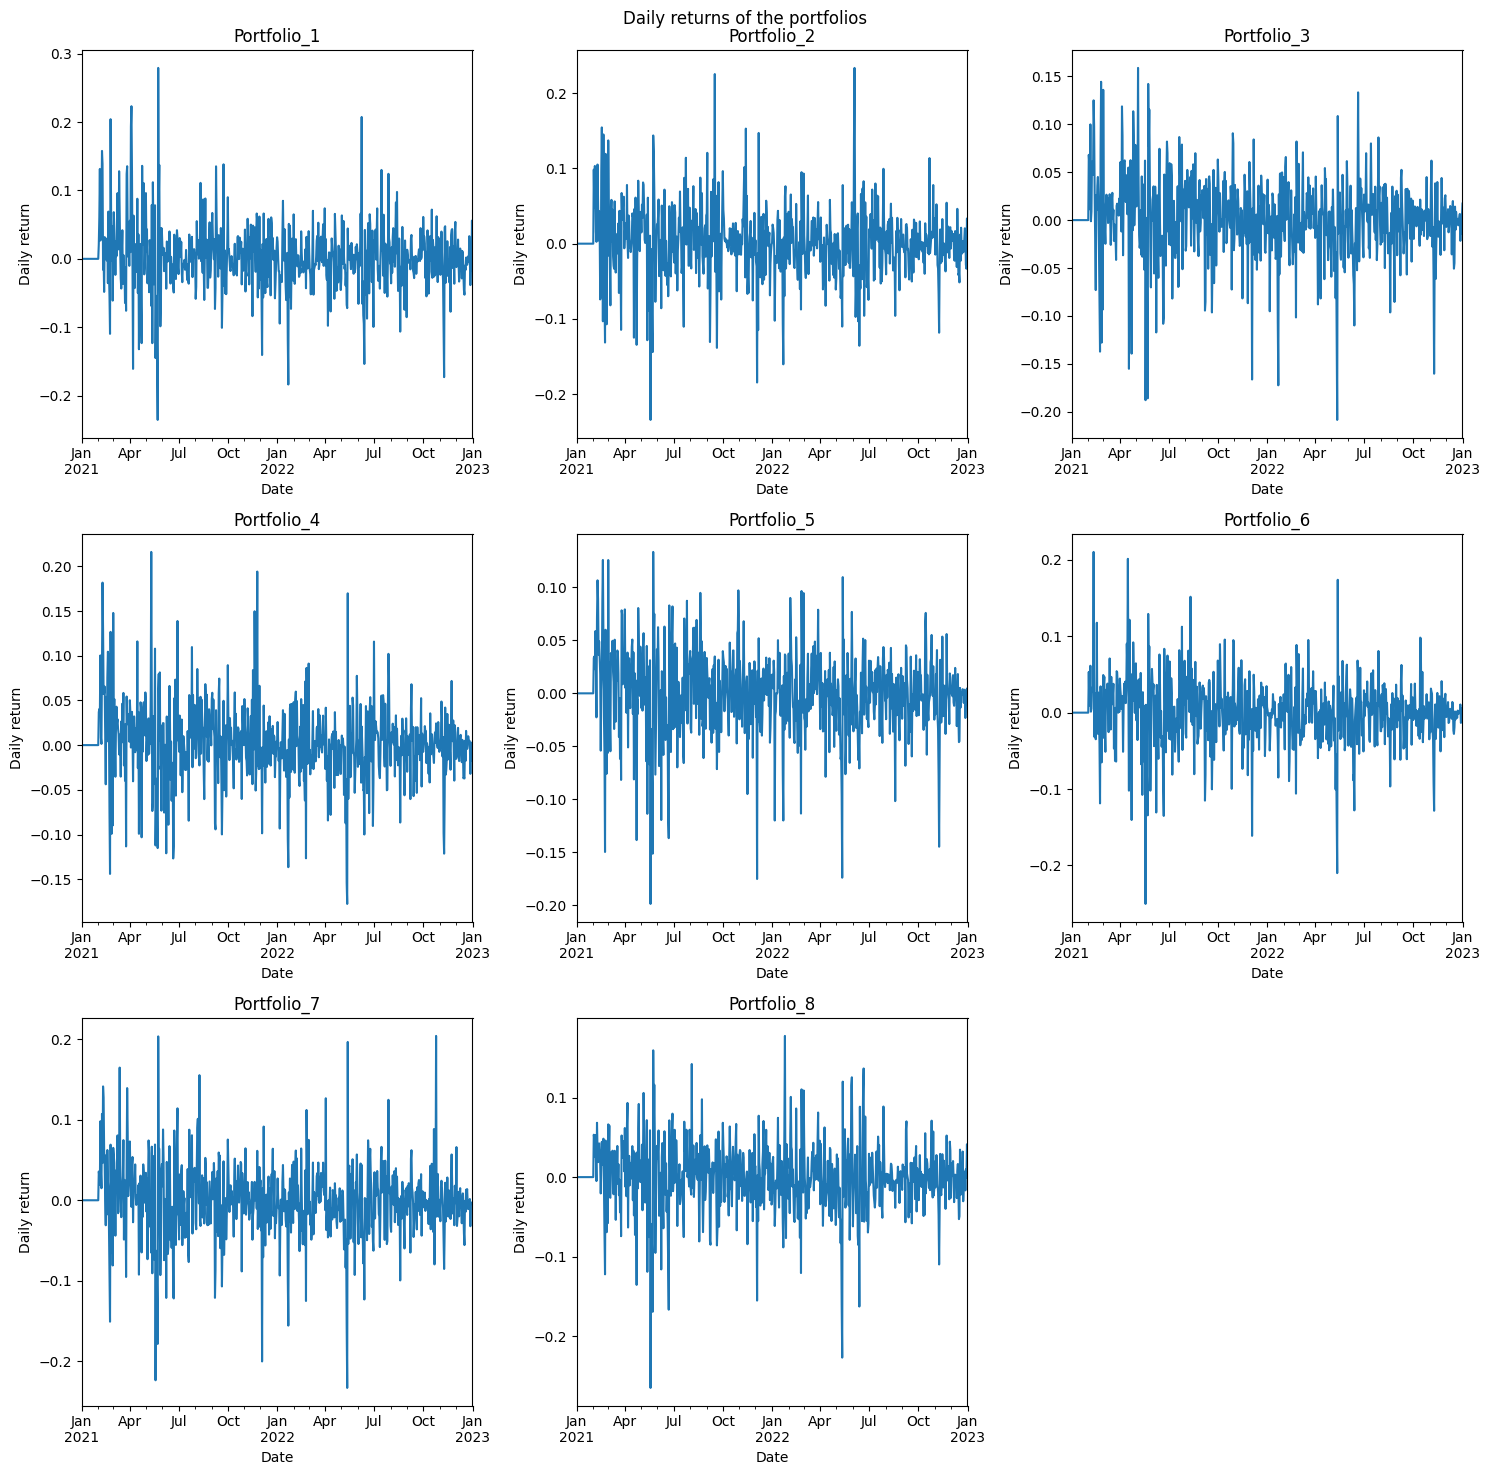

In [121]:


# Créer une liste de noms de portefeuilles
portfolio_names = ["Portfolio_1", "Portfolio_2", "Portfolio_3", "Portfolio_4", 
                   "Portfolio_5", "Portfolio_6", "Portfolio_7", "Portfolio_8"]

# Créer une liste des portefeuilles centralisés
centralized_portfolios = [premier_portefeuille_centralise, deuxieme_portefeuille_centralise,
                          troisieme_portefeuille_centralise, quatrieme_portefeuille_centralise,
                          cinquieme_portefeuille_centralise, sixieme_portefeuille_centralise,
                          septieme_portefeuille_centralise, huitieme_portefeuille_centralise]

# Créer un dictionnaire de données pour le DataFrame
portfolio_values_dict_centralized = {name: portfolio for name, portfolio in zip(portfolio_names, centralized_portfolios)}

# Créer le DataFrame
portfolio_values_df_centralized = pd.DataFrame(portfolio_values_dict_centralized)
portfolio_values_df_centralized = portfolio_values_df_centralized.dropna()
portfolio_values_df_centralized = portfolio_values_df_centralized.iloc[1:]
portfolio_values_df_centralized.index = centralized_df.index

# Calculer les rendements quotidiens
portfolio_daily_returns_centralized = portfolio_values_df_centralized.pct_change()

# Déterminer le nombre de sous-tracés nécessaires
num_subplots = len(portfolio_daily_returns_centralized.columns) // 3 + (len(portfolio_daily_returns_centralized.columns) % 3 > 0)

# Créer les sous-tracés
fig, axes = plt.subplots(num_subplots, 3, figsize=(15, 5 * num_subplots))
fig.suptitle('Daily returns of the portfolios')

# Afficher les graphiques
for i, ax in enumerate(axes.flat):
    if i < len(portfolio_daily_returns_centralized.columns):
        col_name = portfolio_daily_returns_centralized.columns[i]
        portfolio_daily_returns_centralized[col_name].plot(ax=ax, title=col_name, xlabel='Date', ylabel='Daily return')
    else:
        ax.axis('off')  # Masquer les sous-tracés excédentaires s'il y en a

plt.tight_layout()
plt.show()


In [122]:
first_date = data_factors['timestamp'].min()
last_date = portfolio_daily_returns_centralized.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_centralized = portfolio_daily_returns_centralized.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_centralized = merged_centralized.loc[rebalancing_dates[0]:]
merged_centralized = merged_centralized.iloc[1:]
variance_merged_centralized = merged_centralized.std()

### Analyse statistique

In [144]:
#on fait les stats sur les daily return
indicators_centralized = {}

for column in merged_centralized.columns:
    returns = merged_centralized[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators_centralized[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }

# Print the indicators for each returns series
for column, values in indicators_centralized.items():
    print(f"Indicators for {column}:")
    for indicator, value in values.items():
        print(f"{indicator}: {value}")
    print()



Indicators for Portfolio_4:
Mean: 0.002564257103415396
Stddev: 0.044015824330000765
Median: 0.003082029828009647
Min: -0.17765048739420608
Max: 0.21609208940337776
Skewness: 0.12967272600774368
Kurtosis: 3.0387338256079026


In [66]:
columns_to_subtract = ['Portfolio_1', 'Portfolio_2', 'Portfolio_3', 'Portfolio_4', 'Portfolio_5', 'Portfolio_6', 'Portfolio_7', 'Portfolio_8']

for column in columns_to_subtract:
    merged_centralized[column] = merged_centralized[column] - merged_centralized['RF']


### Ratio de sharpe

In [49]:
#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
sharpe_ratios_portfolios = (merged_centralized.mean()) / variance_merged_centralized.std()
print("Le ratio de sharpe des portefeuilles 1 à 9 :","\n",sharpe_ratios_portfolios[0:8])

Le ratio de sharpe des portefeuilles 1 à 9 : 
 Portfolio_1    0.159836
Portfolio_2    0.101723
Portfolio_3    0.056874
Portfolio_4    0.167057
Portfolio_5   -0.002337
Portfolio_6    0.057133
Portfolio_7    0.026866
Portfolio_8   -0.017793
dtype: float64


### Ratio de Treynor/ alpha de Jensen

In [50]:
centralized_rf = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
centralized_rf['Mkt-RF'].fillna(method='ffill', inplace=True)
centralized_rf['Mkt-RF'] = centralized_rf['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_centralized_rf = merged_df.merge(centralized_rf, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_centralized_rf = merged_centralized_rf.loc[rebalancing_dates[0]:]
merged_centralized_rf = merged_centralized_rf.iloc[1:]

merged_centralized_rf.head()

,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF
timestamp,,,,,,,,,,,
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015
2021-02-04,0.131356,0.082706,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123
2021-02-05,0.026753,0.080680,0.121114,0.075505,0.080087,0.067547,0.073394,0.036248,0.063519,0.0,0.0058
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058
2021-02-07,0.078834,0.002044,0.001293,-0.009741,-0.009109,-0.000523,0.006110,-0.014703,0.021444,0.0,0.0058


### Regression pour obtenir les betas et alphas de Jensen

In [78]:

# Perform the regression for each portfolio
for portfolio_index in range(1, 10):
    # Select the portfolio values and the Mkt-RF column
    X = merged_centralized_rf['Mkt-RF']
    y = merged_centralized_rf[f'Portfolio_{portfolio_index}']
    
    # Add a constant term to the independent variable
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Get the intercept (alpha) and slope (beta) coefficients
    alpha_centralized = results.params[0]
    beta_centralized = results.params[1]
    
    # Print the alpha and beta coefficients
    print(f'Portfolio_{portfolio_index}:')
    print(f'Alpha (Jensen): {alpha_centralized}')
    print(f'Beta (Market): {beta_centralized}')
    print()

Portfolio_1:
Alpha (Jensen): 0.002211051965643519
Beta (Market): 0.9668945659725882

Portfolio_2:
Alpha (Jensen): 0.0012218331155011012
Beta (Market): 0.8631491632186671

Portfolio_3:
Alpha (Jensen): 0.0006644494806484474
Beta (Market): 0.7247641113387633

Portfolio_4:
Alpha (Jensen): 0.002057938243443774
Beta (Market): 0.72863776374779

Portfolio_5:
Alpha (Jensen): 0.0007752319798164464
Beta (Market): 0.6985207364816501

Portfolio_6:
Alpha (Jensen): 0.0006241096234047731
Beta (Market): 0.7716782988465907

Portfolio_7:
Alpha (Jensen): -0.00013394788592596563
Beta (Market): 0.9298103120554839

Portfolio_8:
Alpha (Jensen): -0.0005540491522037425
Beta (Market): 0.8879396501442148

Portfolio_9:
Alpha (Jensen): 0.00024568374310872566
Beta (Market): 1.0151355577082932



### Ratio de Treynor

In [79]:

#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
treynor_ratios_portfolios = (merged_centralized_rf.mean()) / beta_centralized
print("Le ratio de treynor des portefeuilles 1 à 9 sont :","\n",treynor_ratios_portfolios[0:8])

Le ratio de treynor des portefeuilles 1 à 9 sont : 
 Portfolio_1    0.002327
Portfolio_2    0.001337
Portfolio_3    0.000766
Portfolio_4    0.002140
Portfolio_5    0.000872
Portfolio_6    0.000734
Portfolio_7    0.000012
Portfolio_8   -0.000409
dtype: float64


### Simulation de FAMA & FRENCH

In [80]:
fm_centralized = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_centralized['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_centralized['Mkt-RF'] = fm_centralized['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_centralized['HML'].fillna(method='ffill', inplace=True)
fm_centralized['HML'] = fm_centralized['HML'].str.replace(',', '.').astype(float)/100
fm_centralized['SMB'].fillna(method='ffill', inplace=True)
fm_centralized['SMB'] = fm_centralized['SMB'].str.replace(',', '.').astype(float)/100

fm_centralized = merged_df.merge(fm_centralized, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_centralized = fm_centralized.loc[rebalancing_dates[0]:]
fm_centralized.head()


,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF,HML,SMB
timestamp,,,,,,,,,,,,,
2021-02-02,0.021151,0.110044,0.063678,0.034783,0.030922,0.061237,0.024386,0.047010,0.018269,0.0,0.0148,-0.0108,-0.0085
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015,0.0070,0.0043
2021-02-04,0.131356,0.082706,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123,0.0037,0.0038
2021-02-05,0.026753,0.080680,0.121114,0.075505,0.080087,0.067547,0.073394,0.036248,0.063519,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058,-0.0047,0.0107


In [114]:

# Select the independent variables (Mkt-RF, SMB, HML)
X = fm_centralized[['Mkt-RF', 'SMB', 'HML']]

# Select the dependent variables (portfolio returns)
y = fm_centralized[['Portfolio_1', 'Portfolio_2', 'Portfolio_3', 'Portfolio_4', 'Portfolio_5', 'Portfolio_6', 'Portfolio_7', 'Portfolio_8']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}
alpha_pvalues = {}

for portfolio in y.columns:
    # Select the current portfolio as the dependent variable
    current_y = y[portfolio]

    # Perform OLS regression
    model = sm.OLS(current_y, X)
    results = model.fit()

    # Get the coefficients
    Bmarket = results.params['Mkt-RF']
    Bsmb = results.params['SMB']
    Bhml = results.params['HML']

    # Get the alpha (intercept)
    alpha = results.params['const']
    #get the p-value for the alpha coefficient
    alpha_pvalue = results.pvalues[0]

    # Store coefficients and alpha in dictionaries
    coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
    alphas[portfolio] = alpha
    alpha_pvalues[portfolio] = alpha_pvalue

# Print the coefficients and alphas for each portfolio
print("Coefficients:")
for portfolio, coeffs in coefficients.items():
    print(f"{portfolio}: Bmarket={coeffs['Bmarket']}, Bsmb={coeffs['Bsmb']}, Bhml={coeffs['Bhml']}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: Alpha={alpha} p-value={alpha_pvalues[portfolio]}")


Coefficients:
Portfolio_1: Bmarket=0.961501598136943, Bsmb=0.3386565420854252, Bhml=0.1523865755762788
Portfolio_2: Bmarket=0.8988204026970165, Bsmb=-0.003076044116250784, Bhml=0.06741455974486985
Portfolio_3: Bmarket=0.7401957600397763, Bsmb=0.00881385068594252, Bhml=0.030466685721396217
Portfolio_4: Bmarket=0.7762491242776941, Bsmb=-0.12414204804965315, Bhml=0.06725971211621647
Portfolio_5: Bmarket=0.6892136830344119, Bsmb=0.1484986630421088, Bhml=0.0405720089702994
Portfolio_6: Bmarket=0.7970888501534195, Bsmb=-0.15314776212462597, Bhml=-0.02078956105174091
Portfolio_7: Bmarket=0.9427518630452788, Bsmb=-0.0814378599373918, Bhml=-0.0072823761154558134
Portfolio_8: Bmarket=0.9407711446358734, Bsmb=-0.24642929482987236, Bhml=0.016681216833179163

Alphas:
Portfolio_1: Alpha=0.00212010236296028 p-value=0.24134551227129192
Portfolio_2: Alpha=0.0012739655921453897 p-value=0.4550906704716836
Portfolio_3: Alpha=0.0007031946612244024 p-value=0.6780180700733704
Portfolio_4: Alpha=0.00197412096

# Etude des cryptos décentralisées

In [126]:
portfolio_1_3_decentralized = get_portfolio_compo(decentralized_df, rebalancing_dates, portfolio_index=3, horizon=15)
premier_portefeuille_decentralise = compute_portfolio_values(decentralized_df, portfolio_1_3_decentralized, rebalancing_dates, portfolio_index=1, horizon=15, initial_value=initial_portfolio_value)
deuxieme_portefeuille_decentralise = compute_portfolio_values(decentralized_df, portfolio_1_3_decentralized, rebalancing_dates, portfolio_index=2, horizon=15, initial_value=initial_portfolio_value)
troisieme_portefeuille_decentralise = compute_portfolio_values(decentralized_df, portfolio_1_3_decentralized, rebalancing_dates, portfolio_index=3, horizon=15, initial_value=initial_portfolio_value)


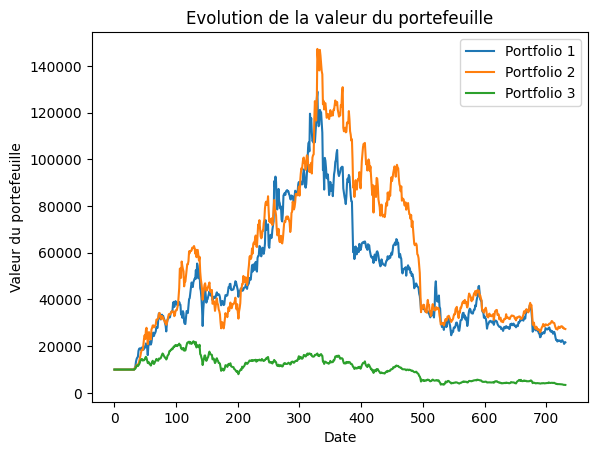

In [127]:
#on plot les 5 portefeuille
plt.plot(premier_portefeuille_decentralise, label="Portfolio 1")
plt.plot(deuxieme_portefeuille_decentralise, label="Portfolio 2")
plt.plot(troisieme_portefeuille_decentralise, label="Portfolio 3")
plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()
plt.show()

### Daily returns

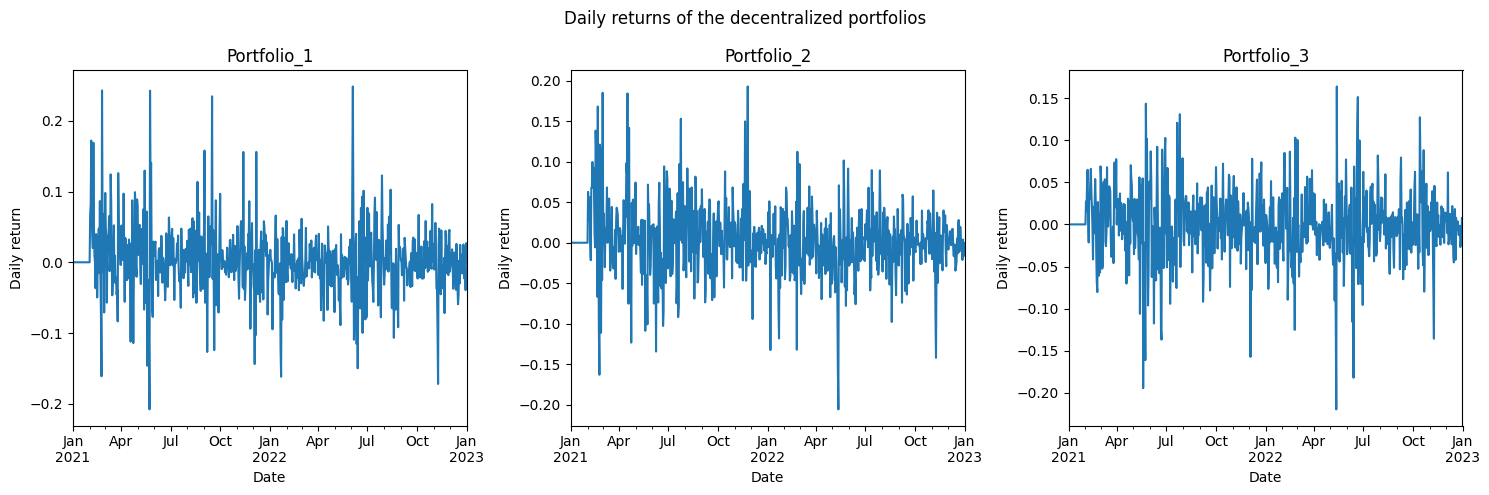

In [128]:
# Créer une liste de noms de portefeuilles décentralisés
portfolio_names_decentralized = ["Portfolio_1", "Portfolio_2", "Portfolio_3"]

# Créer une liste des portefeuilles décentralisés
decentralized_portfolios = [premier_portefeuille_decentralise, deuxieme_portefeuille_decentralise,
                            troisieme_portefeuille_decentralise]

# Créer un dictionnaire de données pour le DataFrame des portefeuilles décentralisés
portfolio_values_dict_decentralized = {name: portfolio for name, portfolio in zip(portfolio_names_decentralized, decentralized_portfolios)}

# Créer le DataFrame des portefeuilles décentralisés
portfolio_values_df_decentralized = pd.DataFrame(portfolio_values_dict_decentralized)
portfolio_values_df_decentralized = portfolio_values_df_decentralized.dropna()
portfolio_values_df_decentralized = portfolio_values_df_decentralized.iloc[1:]
portfolio_values_df_decentralized.index = decentralized_df.index

# Calculer les rendements quotidiens des portefeuilles décentralisés
portfolio_daily_returns_decentralized = portfolio_values_df_decentralized.pct_change()

# Déterminer le nombre de sous-tracés nécessaires
num_subplots_decentralized = len(portfolio_daily_returns_decentralized.columns) // 3 + (len(portfolio_daily_returns_decentralized.columns) % 3 > 0)

# Créer les sous-tracés pour les portefeuilles décentralisés
fig_decentralized, axes_decentralized = plt.subplots(num_subplots_decentralized, 3, figsize=(15, 5 * num_subplots_decentralized))
fig_decentralized.suptitle('Daily returns of the decentralized portfolios')

# Afficher les graphiques des portefeuilles décentralisés
for i, ax in enumerate(axes_decentralized.flat):
    if i < len(portfolio_daily_returns_decentralized.columns):
        col_name_decentralized = portfolio_daily_returns_decentralized.columns[i]
        portfolio_daily_returns_decentralized[col_name_decentralized].plot(ax=ax, title=col_name_decentralized, xlabel='Date', ylabel='Daily return')
    else:
        ax.axis('off')  # Masquer les sous-tracés excédentaires s'il y en a

plt.tight_layout()
plt.show()


In [129]:
first_date = data_factors['timestamp'].min()
last_date = portfolio_daily_returns_decentralized.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_decentralized = portfolio_daily_returns_decentralized.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_decentralized = merged_decentralized.loc[rebalancing_dates[0]:]
merged_decentralized = merged_decentralized.iloc[1:]
variance_merged_decentralized = merged_decentralized.std()

### Analyse statistique

In [130]:
#on fait les stats sur les daily return
indicators_decentralized = {}

for column in merged_decentralized.columns:
    returns = merged_decentralized[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators_centralized[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }

# Print the indicators for each returns series
for column, values in indicators_centralized.items():
    print(f"Indicators for {column}:")
    for indicator, value in values.items():
        print(f"{indicator}: {value}")
    print()



Indicators for Portfolio_1:
Mean: 0.002288686738141782
Stddev: 0.048949461027386044
Median: 0.0010837845134297197
Min: -0.20788781996894168
Max: 0.248472557684839
Skewness: 0.5014594539817334
Kurtosis: 4.418329307819688

Indicators for Portfolio_2:
Mean: 0.0024322500295229205
Stddev: 0.044574111901996706
Median: 0.0018035613359446145
Min: -0.20573252345104742
Max: 0.19290609225522215
Skewness: 0.11419069261500854
Kurtosis: 2.7530215035320422

Indicators for Portfolio_3:
Mean: -0.0005886606654660861
Stddev: 0.043062039161796704
Median: -0.000901738207161995
Min: -0.2195520524216722
Max: 0.16369289732010528
Skewness: -0.3820293988546324
Kurtosis: 2.8629351162081402

Indicators for Portfolio_4:
Mean: 0.0002895576322804823
Stddev: 0.044923544495791286
Median: 0.0031610756278268592
Min: -0.256422227540003
Max: 0.2501680036366254
Skewness: -0.46317141263110495
Kurtosis: 5.23625238830749

Indicators for Portfolio_5:
Mean: 0.000846323370176227
Stddev: 0.04555223263150102
Median: 0.002088019827

In [131]:
portfolio_names = ['Portfolio_1', 'Portfolio_2', 'Portfolio_3']

for portfolio in portfolio_names:
    merged_decentralized[portfolio] -= merged_decentralized['RF']


### Ratio de Sharpe

In [132]:
#on calcul le ration de sharpe pour chaque portfolio de 1 a 3
sharpe_ratios_portfolios = (merged_decentralized.mean()) / variance_merged_decentralized.std()
print("Le ratio de sharpe des portefeuilles 1 à 5 :","\n",sharpe_ratios_portfolios[0:3])

Le ratio de sharpe des portefeuilles 1 à 5 : 
 Portfolio_1    0.098757
Portfolio_2    0.105032
Portfolio_3   -0.027022
dtype: float64


In [133]:
decentralized_rf = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
decentralized_rf['Mkt-RF'].fillna(method='ffill', inplace=True)
decentralized_rf['Mkt-RF'] = decentralized_rf['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_decentralized_rf = merged_decentralized.merge(decentralized_rf, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_decentralized_rf = merged_decentralized_rf.loc[rebalancing_dates[0]:]
merged_decentralized_rf = merged_decentralized_rf.iloc[1:]

merged_decentralized_rf.head()

,Portfolio_1,Portfolio_2,Portfolio_3,RF,Mkt-RF
timestamp,,,,,
2021-02-03,0.081401,0.040924,0.015677,0.0,0.0015
2021-02-04,0.172020,0.027140,0.051302,0.0,0.0123
2021-02-05,0.078056,0.055916,0.064817,0.0,0.0058
2021-02-06,0.037875,0.000058,0.005885,0.0,0.0058
2021-02-07,0.020068,-0.021562,-0.021359,0.0,0.0058


### Regression pour obtenir l'alpha de Jensen et le Beta Market

In [135]:

# Perform the regression for each portfolio
for portfolio_index in range(1, 4):
    # Select the portfolio values and the Mkt-RF column
    X = merged_decentralized_rf['Mkt-RF']
    y = merged_decentralized_rf[f'Portfolio_{portfolio_index}']
    
    # Add a constant term to the independent variable
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Get the intercept (alpha) and slope (beta) coefficients
    alpha_decentralized = results.params[0]
    alpha_pvalue_decentralized = results.pvalues[0]
    beta_decentralized = results.params[1]
    
    # Print the alpha and beta coefficients
    print(f'Portfolio_{portfolio_index}:')
    print(f'Alpha (Jensen): {alpha_decentralized} p-value: {alpha_pvalue_decentralized}')
    print(f'Beta (Market): {beta_decentralized}')
    print()

Portfolio_1:
Alpha (Jensen): 0.0020364021180471464 p-value: 0.2601414192255434
Beta (Market): 0.830688582157026

Portfolio_2:
Alpha (Jensen): 0.002192006863272415 p-value: 0.18208820276407553
Beta (Market): 0.792972043041684

Portfolio_3:
Alpha (Jensen): -0.0007960041375457448 p-value: 0.6128605623916901
Beta (Market): 0.88026893270068



In [138]:

#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
treynor_ratios_portfolios = (merged_decentralized_rf.mean()) / beta_decentralized
print("Le ratio de treynor des portefeuilles 1 à 5 sont :","\n",treynor_ratios_portfolios[0:3])

Le ratio de treynor des portefeuilles 1 à 5 sont : 
 Portfolio_1    0.002461
Portfolio_2    0.002631
Portfolio_3   -0.000748
dtype: float64


In [139]:
fm_decentralized = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')

fm_decentralized['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_decentralized['Mkt-RF'] = fm_decentralized['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_decentralized['HML'].fillna(method='ffill', inplace=True)
fm_decentralized['HML'] = fm_decentralized['HML'].str.replace(',', '.').astype(float)/100
fm_decentralized['SMB'].fillna(method='ffill', inplace=True)
fm_decentralized['SMB'] = fm_decentralized['SMB'].str.replace(',', '.').astype(float)/100

fm_decentralized = merged_decentralized.merge(fm_decentralized, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_decentralized = fm_decentralized.loc[rebalancing_dates[0]:]
fm_decentralized.head()

,Portfolio_1,Portfolio_2,Portfolio_3,RF,Mkt-RF,HML,SMB
timestamp,,,,,,,
2021-02-02,0.066886,0.062751,0.027216,0.0,0.0148,-0.0108,-0.0085
2021-02-03,0.081401,0.040924,0.015677,0.0,0.0015,0.0070,0.0043
2021-02-04,0.172020,0.027140,0.051302,0.0,0.0123,0.0037,0.0038
2021-02-05,0.078056,0.055916,0.064817,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.037875,0.000058,0.005885,0.0,0.0058,-0.0047,0.0107


### Regression Fama & French

In [141]:

# Select the independent variables (Mkt-RF, SMB, HML)
X = fm_decentralized[['Mkt-RF', 'SMB', 'HML']]

# Select the dependent variables (portfolio returns)
y = fm_decentralized[['Portfolio_1', 'Portfolio_2', 'Portfolio_3']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}
alpha_pvalues = {}

for portfolio in y.columns:
    # Select the current portfolio as the dependent variable
    current_y = y[portfolio]

    # Perform OLS regression
    model = sm.OLS(current_y, X)
    results = model.fit()

    # Get the coefficients
    Bmarket = results.params['Mkt-RF']
    Bsmb = results.params['SMB']
    Bhml = results.params['HML']

    # Get the alpha (intercept)
    alpha = results.params['const']
    #get the p-value for the alpha coefficient
    alpha_pvalue = results.pvalues[0]

    # Store coefficients and alpha in dictionaries
    coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
    alphas[portfolio] = alpha
    alpha_pvalues[portfolio] = alpha_pvalue

# Print the coefficients and alphas for each portfolio
print("Coefficients:")
for portfolio, coeffs in coefficients.items():
    print(f"{portfolio}: Bmarket={coeffs['Bmarket']}, Bsmb={coeffs['Bsmb']}, Bhml={coeffs['Bhml']}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: Alpha={alpha} p-value={alpha_pvalues[portfolio]}")


Coefficients:
Portfolio_1: Bmarket=0.828893455170367, Bsmb=0.35384514514694915, Bhml=0.15349554410450733
Portfolio_2: Bmarket=0.8522687768634509, Bsmb=-0.20022543985806351, Bhml=0.053368819807340595
Portfolio_3: Bmarket=0.898121601574177, Bsmb=-0.1268752769803988, Bhml=-0.01737167165925978

Alphas:
Portfolio_1: Alpha=0.0020156002896429123 p-value=0.2680626174061484
Portfolio_2: Alpha=0.002143100297170588 p-value=0.19520779424421417
Portfolio_3: Alpha=-0.0007869147209652595 p-value=0.619317871502572
